## Initial value problems

### with interval arithmetic

In [1]:
using IntervalArithmetic
using DifferentialEquations
using Plots
include("fnc.jl");

In [2]:
function myeuler(df, t0, x0, h, n) # derivative, initial conditions, step size, number of steps
    t = t0 .+ h .* (0:n)
    f = zeros(typeof(x0), n+1)
    f[1] = x0
    for i in 1:n
        f[i+1] = f[i] + df(f[i]) * h
    end
    t, f
end

myeuler (generic function with 1 method)

In [3]:
function logistic(u, p, t) 
    r, k = p
    r*u*(1-u/k)
end
t_span = (0.0, 10.0)
p = [ 1.2, 50.0 ]
u0 =  1.0  
ivp_logistic = ODEProblem(logistic, u0, t_span, p)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: 1.0

In [4]:
t_logistic, u_logistic = rk4(ivp_logistic, 1000)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  9.91, 9.92, 9.93, 9.94, 9.950000000000001, 9.96, 9.97, 9.98, 9.99, 10.0], [1.0, 1.0118279872693363, 1.023792952761366, 1.0358964132871615, 1.04813990080098, 1.0605249625116053, 1.0730531609934895, 1.0857260742976576, 1.0985452960623454, 1.111512435623333  …  49.98323550532559, 49.98343541078277, 49.98363293328079, 49.983828101207045, 49.9840209426112, 49.9842114852092, 49.98439975638722, 49.98458578320558, 49.98476959240264, 49.984951210398584])

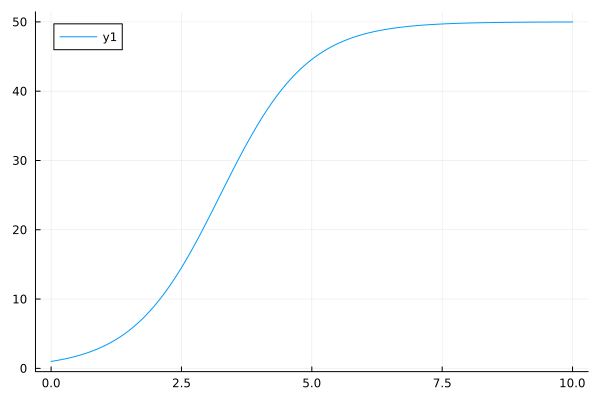

In [5]:
plot(t_logistic, u_logistic)

In [6]:
u0 = 1.0 ± 0.0001
ivp_interval = ODEProblem(logistic, u0, t_span, p)
t_interval, u_interval = rk4(ivp_interval, 100)

([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  9.1, 9.200000000000001, 9.3, 9.4, 9.5, 9.600000000000001, 9.700000000000001, 9.8, 9.9, 10.0], Interval{Float64}[[0.999899, 1.00011], [1.12451, 1.12475], [1.26426, 1.26452], [1.42087, 1.42116], [1.59624, 1.59657], [1.79245, 1.79283], [2.01179, 2.01221], [2.25671, 2.25718], [2.52987, 2.5304], [2.83413, 2.83473]  …  [43.8735, 56.047], [42.995, 56.9357], [41.9692, 57.9704], [40.7658, 59.1816], [39.3464, 60.6081], [37.6608, 62.3], [35.643, 64.3233], [33.2041, 66.767], [30.2216, 69.754], [26.5212, 73.4582]])

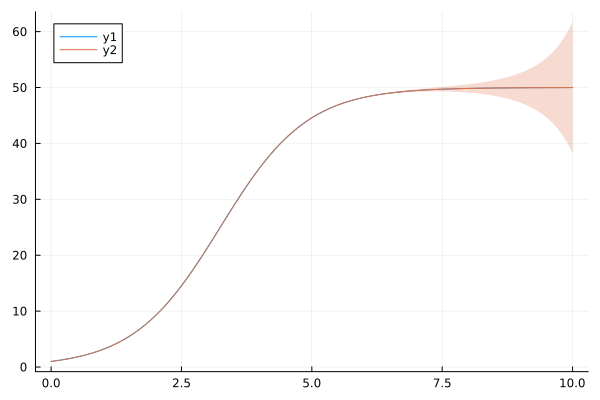

In [7]:
plot(t_interval, mid.(u_interval))
plot!(t_interval, mid.(u_interval), ribbon = radius.(u_interval)/2, fillalpha = 0.25 )

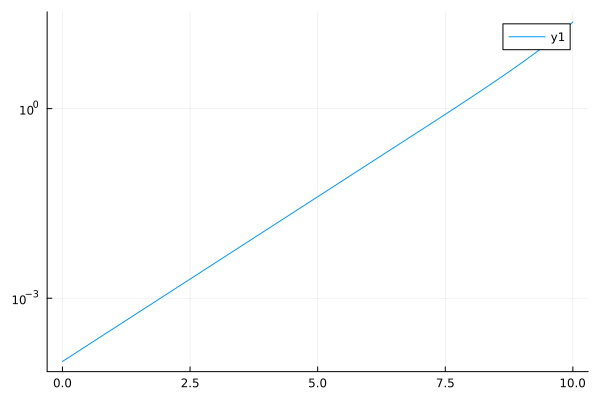

In [8]:
plot(t_interval, radius.(u_interval), yscale = :log10)

Try an interval for $r$ or $k$. Doesn't work (intervals not supported) for ODEProblem. 

Fall back to my_euler function. (Could write my_rk4 function.)

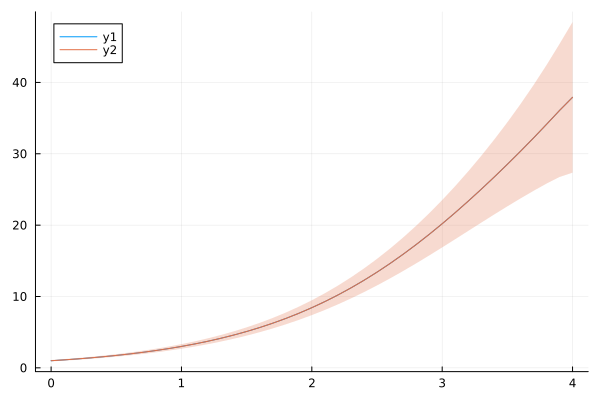

In [9]:
# u0 =  @interval 1.0  
u0 = 0.8 .. 1.2
function logistic2(u) 
    r = 1.2 ± 0.01
    k = 50.0
    r*u*(1-u/k)
end
t_interval, u_interval = myeuler(logistic2, 0.0, u0, 0.1, 40)
plot(t_interval, mid.(u_interval))
plot!(t_interval, mid.(u_interval), ribbon = radius.(u_interval)/2, fillalpha = 0.25 )
# plot!(t_interval, mid.(u_interval) .- radius.(u_interval)/2 )

In [10]:
# Simplified RK4 for autonomous functions (f does not depend on t)
function myrk4(df, t0, x0, h, n) # derivative, initial conditions, step size, number of steps
    t = t0 .+ h .* (0:n)
    f = zeros(typeof(x0), n+1)
    f[1] = x0
    for i in 1:n
        k₁ = h*df( f[i]     )
        k₂ = h*df( f[i]+k₁/2)
        k₃ = h*df( f[i]+k₂/2)
        k₄ = h*df( f[i]+k₃  )
        f[i+1] = f[i] + (k₁ + 2(k₂+k₃) + k₄)/6
    end
    t, f
end

myrk4 (generic function with 1 method)

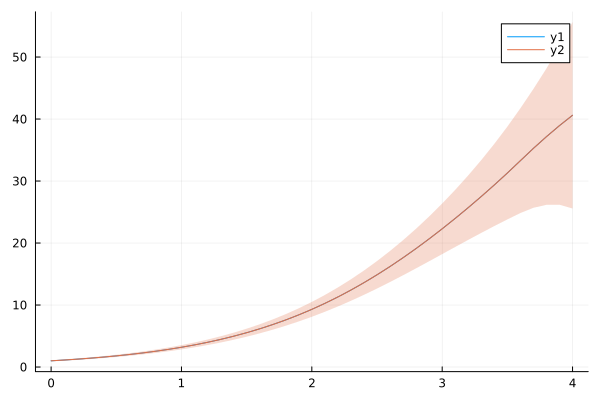

In [11]:
t_interval_rk4, u_interval_rk4 = myrk4(logistic2, 0.0, u0, 0.1, 40)
plot(t_interval_rk4, mid.(u_interval_rk4))
plot!(t_interval_rk4, mid.(u_interval_rk4), ribbon = radius.(u_interval_rk4)/2, fillalpha =0.25 )
# plot!(t_interval, mid.(u_interval), label = "Euler")
# plot!(t_interval, mid.(u_interval), ribbon = radius.(u_interval)/2, fillalpha = 0.25, label ="Euler" )

## Find the functional form of an IVP from data

Based on examples at https://docs.sciml.ai/DataDrivenDiffEq/stable/libs/datadrivensparse/examples/example_01/

### Lorentz system

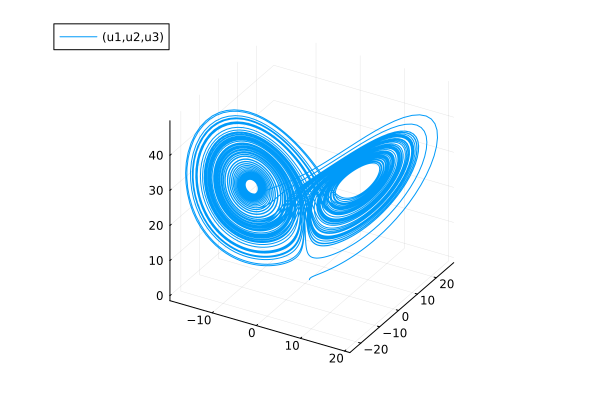

In [155]:
function lorenz(u, p, t)
    x, y, z = u

    ẋ = 10.0 * (y - x)
    ẏ = x * (28.0 - z) - y
    ż = x * y - (8 / 3) * z
    return [ẋ, ẏ, ż]
end
u0 = [1.0;0.0;0.0]
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz, u0, tspan)
sol = solve(prob, Tsit5())
plot(sol,vars=(1,2,3))

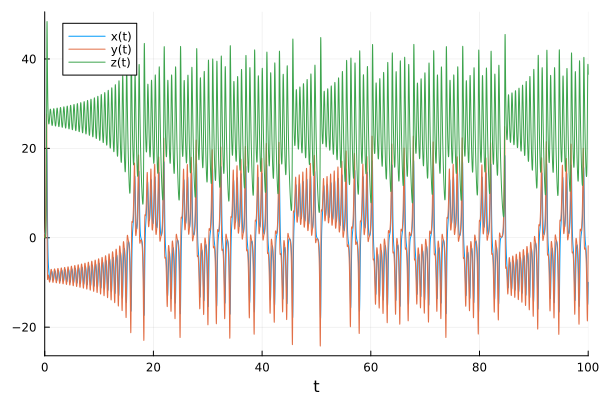

In [156]:
plot(sol,vars=(0,1), label = "x(t)")
plot!(sol,vars=(0,2), label = "y(t)")
plot!(sol,vars=(0,3), label = "z(t)")

Sample this solution at a few points.

In [157]:
tspan = (0.0, 25.0)
dt = 0.25
prob = ODEProblem(lorenz, u0, tspan)
sol = solve(prob, Tsit5(), saveat = dt)

retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
  0.0
  0.25
  0.5
  0.75
  1.0
  1.25
  1.5
  1.75
  2.0
  2.25
  2.5
  2.75
  3.0
  ⋮
 22.25
 22.5
 22.75
 23.0
 23.25
 23.5
 23.75
 24.0
 24.25
 24.5
 24.75
 25.0
u: 101-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [6.913885219975945, 14.598536604676408, 4.006373392592713]
 [6.503654894206176, -8.508354683856535, 38.0919973428835]
 [-7.35545770146262, -8.815592067290407, 25.482200995818715]
 [-9.395644809950745, -9.093947245418292, 28.55396229102896]
 [-7.49604301985204, -7.246797334668034, 26.153970092209992]
 [-9.075206131065917, -9.954372618550357, 26.566620863383704]
 [-8.321426582987536, -7.232581663013501, 28.181500334764067]
 [-7.883336668582669, -8.759004642261429, 25.013756177544856]
 [-9.484097731245456, -8.969500826167938, 28.874903843609093]
 [-7.3282493830268285, -7.1737279581007485, 25.82903382412996]
 [-9.259545471665575, -10.188638877518876, 26.74067107257844]
 [-8.151339789291454,

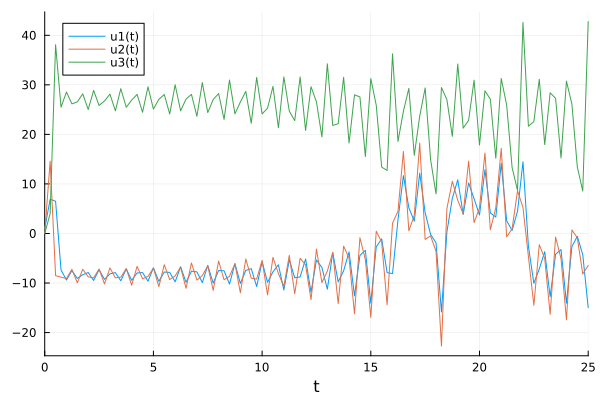

In [158]:
using Plots
plot(sol)

Start the automatic discovery

In [159]:
using DataDrivenDiffEq
using ModelingToolkit
using OrdinaryDiffEq
using DataDrivenSparse
using LinearAlgebra
ddprob = DataDrivenProblem(sol)

@variables t x(t) y(t) z(t)
u = [x; y; z]
basis = Basis(polynomial_basis(u, 5), u, iv = t)
opt = STLSQ(exp10.(-5:0.1:-1))


STLSQ{Vector{Float64}, Float64}([1.0e-5, 1.2589254117941661e-5, 1.584893192461114e-5, 1.9952623149688786e-5, 2.5118864315095822e-5, 3.1622776601683795e-5, 3.9810717055349695e-5, 5.011872336272725e-5, 6.309573444801929e-5, 7.943282347242822e-5  …  0.012589254117941675, 0.015848931924611134, 0.0199526231496888, 0.025118864315095794, 0.03162277660168379, 0.039810717055349734, 0.05011872336272722, 0.06309573444801933, 0.07943282347242814, 0.1], 0.0)

In [160]:
ddsol = solve(ddprob, basis, opt, options = DataDrivenCommonOptions(digits = 1))
ddsol.basis

Model ##Basis#414 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [161]:
@show size(p)
p = ddsol.out[1].coefficients

size(p) = (3, 56)


3×56 Matrix{Float64}:
 0.0  -10.0  0.0  0.0  0.0  0.0  10.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   28.0  0.0  0.0  0.0  0.0  -1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [162]:
[ (div(j,3)+1, rem(j, 3), x) for (j,x) in enumerate(p) if x != 0.0 ]

7-element Vector{Tuple{Int64, Int64, Float64}}:
 (2, 1, -9.999999999999996)
 (2, 2, 28.00000000000001)
 (7, 1, 9.999999999999991)
 (7, 2, -1.0000000000000044)
 (9, 0, 0.9999999999999997)
 (23, 0, -2.6666666666666665)
 (23, 2, -1.0000000000000002)

In [163]:
system = get_basis(ddsol)
get_parameter_map(system)

7-element Vector{Pair{Sym{Real, Base.ImmutableDict{DataType, Any}}, Float64}}:
 p₁ => -9.9
 p₂ => 9.9
 p₃ => 28.0
 p₄ => -1.0
 p₅ => -1.0
 p₆ => 0.9
 p₇ => -2.6

Add some noise

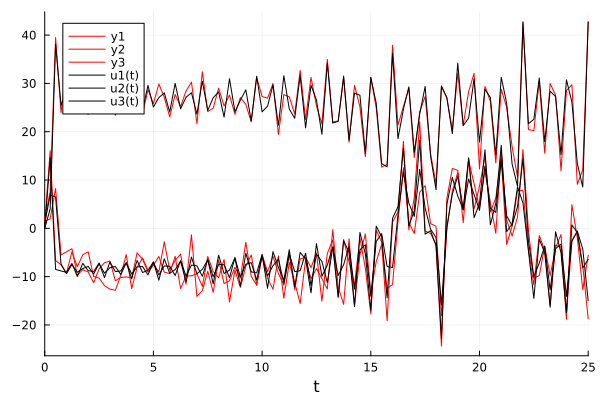

In [186]:
X = sol[:, :] + 2.5 .* randn(rng, size(sol));
ts = sol.t;

plot(ts, X', color = :red)
plot!(sol, color = :black)

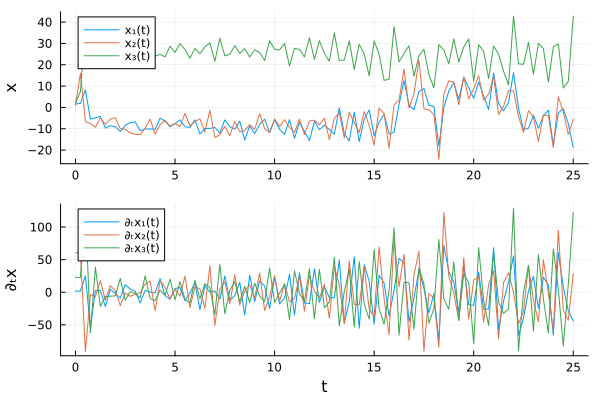

In [187]:
prob = ContinuousDataDrivenProblem(X, ts)
plot(prob, size = (600,400))

In [188]:
ddsol2 = solve(prob, basis, opt, options = DataDrivenCommonOptions(digits = 1))
ddsol2.basis

Model ##Basis#469 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (20):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [189]:
system = get_basis(ddsol2)
get_parameter_map(system)

20-element Vector{Pair{Sym{Real, Base.ImmutableDict{DataType, Any}}, Float64}}:
  p₁ => -13.4
  p₂ => -3.8
  p₃ => -0.1
  p₄ => 1.7
  p₅ => 1.2
  p₆ => 0.1
  p₇ => 77.6
  p₈ => 4.4
  p₉ => -0.8
 p₁₀ => 1.3
 p₁₁ => 0.1
 p₁₂ => 0.2
 p₁₃ => -14.1
 p₁₄ => -0.9
 p₁₅ => 0.3
 p₁₆ => 0.7
 p₁₇ => 3.8
 p₁₈ => 0.1
 p₁₉ => -7.4
 p₂₀ => 0.2

Now add some noise to the data and try to fit the model again.

Use a different problem for variety: a pendulum with some time-dependent forcing and friction. This is a bit complicated!

In [130]:
using StableRNGs

rng = StableRNG(1337)

function pendulum(u, p, t)
    x = u[2]
    y = -9.81sin(u[1]) - 0.3u[2]^3 - 3.0 * cos(u[1]) - 10.0 * exp(-((t - 5.0) / 5.0)^2)
    return [x; y]
end

u0 = [0.99π; -1.0]
tspan = (0.0, 15.0)
prob = ODEProblem(pendulum, u0, tspan)
sol = solve(prob, Tsit5(), saveat = 0.01);

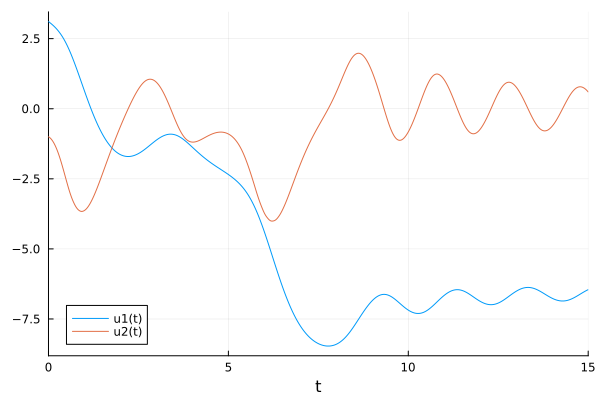

In [133]:
plot(sol)

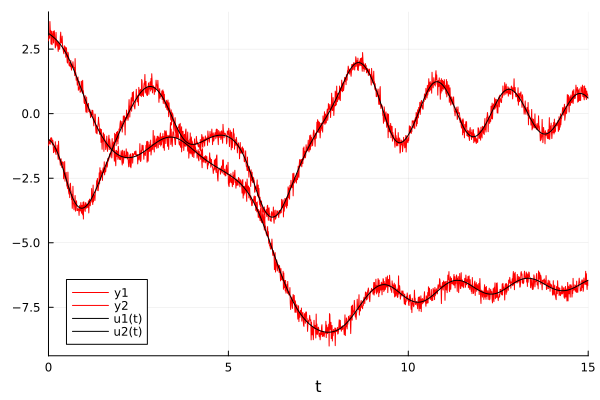

In [131]:
X = sol[:, :] + 0.2 .* randn(rng, size(sol));
ts = sol.t;

plot(ts, X', color = :red)
plot!(sol, color = :black)

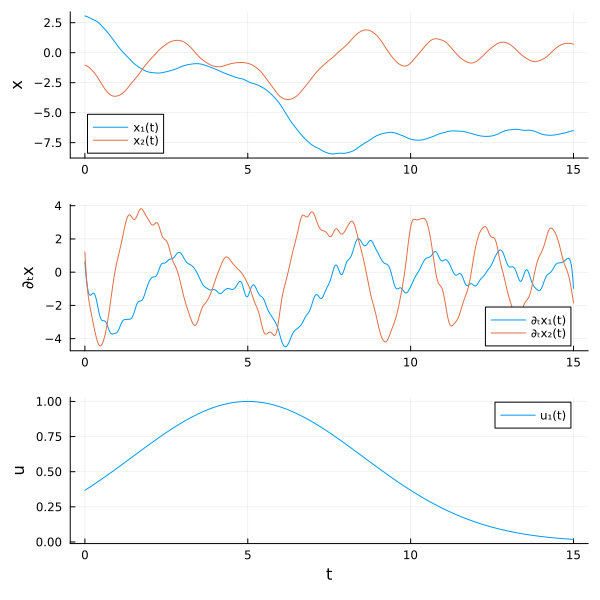

In [132]:
prob = ContinuousDataDrivenProblem(X, ts, GaussianKernel(),
                                   U = (u, p, t) -> [exp(-((t - 5.0) / 5.0)^2)],
                                   p = ones(2))

plot(prob, size = (600,600))

In [134]:
@variables u[1:2] c[1:1]
@parameters w[1:2]
u = collect(u)
c = collect(c)
w = collect(w)

h = Num[sin.(w[1] .* u[1]); cos.(w[2] .* u[1]); polynomial_basis(u, 5); c]

basis = Basis(h, u, parameters = w, controls = c);

In [135]:
sampler = DataProcessing(split = 0.8, shuffle = true, batchsize = 30, rng = rng)
λs = exp10.(-10:0.1:0)
opt = STLSQ(λs)
res = solve(prob, basis, opt,
            options = DataDrivenCommonOptions(data_processing = sampler, digits = 1))

"DataDrivenSolution{Float64}"

In [140]:
res.basis

Model ##Basis#395 with 2 equations
States (2):
  u[1]
  u[2]
Parameters (19):
  w[1]
  w[2]
  p₃
  p₄
  p₅
  p₆
⋮

In [144]:
res.out[1].coefficients

2×24 Matrix{Float64}:
  0.0       0.0      0.0      0.0      …  0.0        0.0        0.0    0.0
 -8.65622  -5.83987  9.27626  7.64733     0.0492372  0.0307947  0.0  -10.3995

In [145]:
system = get_basis(res)
params = get_parameter_map(system)

19-element Vector{Pair{A, Float64} where A}:
 w[1] => 1.0
 w[2] => 1.0
   p₃ => 0.9
   p₄ => -8.6
   p₅ => -5.8
   p₆ => 9.2
   p₇ => 7.6
   p₈ => 1.8
   p₉ => 0.1
  p₁₀ => 2.8
  p₁₁ => 5.3
  p₁₂ => 2.8
  p₁₃ => 0.5
  p₁₄ => 2.7
  p₁₅ => 2.5
  p₁₆ => 0.7
  p₁₇ => 0.6
  p₁₈ => 0.5
  p₁₉ => -10.3

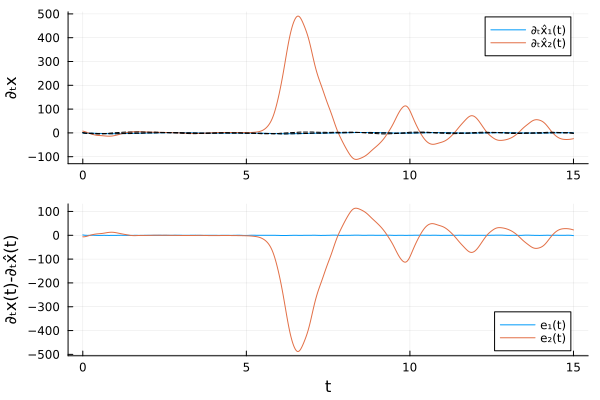

In [152]:
 plot(res)